In [1]:
import sys
sys.path.append('..')
from src.data.docx  import read_docx,process_docx,find_content
import glob
import json
import os
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore")
from src.features.segment_transcript import CreateBlocks
from functools import reduce
import heapq
from gensim.corpora import Dictionary
from gensim import models
from gensim import similarities
import re
import statistics
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display, HTML


'''emphasize titles'''
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import spacy
from nltk.stem import PorterStemmer

from sklearn.metrics.pairwise import cosine_similarity


In [2]:
'''Defining CONSTS'''
docx_path = '../data/raw/docx'
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')
lemmatizing_method ='lemma' #'stemm'

videos_ids = list(map(lambda fl: fl.split('\\')[-1].split('.')[0],glob.glob(docx_path + '/*')))

desired_videos =['NuY7szYSXSw','XX7ePR21Ook','h9wxtqoa1jY','GJpt_3ie4WU','bTyxpoi2dmM']#['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ','zWg7U0OEAoE','tORLeHHtazM'] #['zWg7U0OEAoE','tORLeHHtazM'] #['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ']
videos_ids = list(filter(lambda x: x in desired_videos,videos_ids))

In [3]:
f_read = {
    'statbook':'statbook',
    'Dsa':'Dsa',
    'MIT6_042JF10_notes':'MIT6_042JF10_notes'
}

docxs_chapter_keyword = {
    'statbook':'Topic',
    'Dsa': 'Chapter',
    'MIT6_042JF10_notes':'Chapter'
}



In [4]:
video_to_paper = {}
paper_content ={}
for vid in videos_ids:
    doc_path = glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0]
    doc_name = doc_path.split('\\')[-1].split('.')[0]
    video_to_paper[vid] = doc_name    
    if doc_name not in paper_content.keys():    
        full_text,font_sizes = read_docx(doc_path)
        paper_content[doc_name] = find_content(f_read[doc_name],
                                               full_text,
                                               font_sizes,
                                               docxs_chapter_keyword[doc_name],
                                              lemmatizing=lemmatizing_method)

In [5]:
'''Select transcript for only wanted videos'''
transcript_filespath = list(filter(lambda x: x.split('\\')[-1].split('.')[0] in videos_ids,transcript_filespath))

'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript
#print(transcripts_jsons)

'''Read the videos metadata to perform on them the segmentation'''
df_videos = pd.read_csv(topic_dataset_path)

''' Transfer topic shifts time to seconds units instead HH:MM:SS'''
def topic_shifts_seconds(topic_shifts):
    tp_shift_sec=[]
    for tp in topic_shifts:
        intervals = tp.split(':')
        seconds = int(intervals[2])
        minutes = int(intervals[1]) * 60
        hours = int(intervals[0]) * 60 *60
        tp_shift_sec.append(seconds + minutes + hours)
    return tp_shift_sec
for video_id in transcripts_jsons.keys():    
    df_videos.at[df_videos['video id'] == video_id,'topic shifts(ends)'] =\
    topic_shifts_seconds(\
                         df_videos[df_videos['video id'] == \
                                   video_id]['topic shifts(ends)'])

# EXTRACT MAIN CHAPTERS OF BOOKS AND ORAGANIZE THE PAPER AS DIFFERENT DOCUMENTS GROUPS

In [6]:
'''Find the following for each paper:
    1) main chapter title index. for example [10,15....]
    2) range of subsection within each main chapter . for example [(0,9),(11,14)...]
    
    '''

#paper_mainchapter_indexes = {}
paper_sec_within_main_indexes = {}
main_section_as_one_doc = {}
paper_subsec_as_one_doc = {}
first_dep_section_as_one_doc = {}

def get_sub_titles(all_titles,main_tl_indexes):
    subsec_mainchapter_indexes = [range(main_tl_indexes[index],main_tl_indexes[index + 1])
                                  for index in range(len(main_tl_indexes) - 1)]
    subsec_mainchapter_indexes.append(range(main_tl_indexes[-1],len(all_titles)))
    return subsec_mainchapter_indexes


for doc_name in paper_content.keys():
    '''
        first element array of subtitles by dividing based on main chapters like 4 number theory
        second element array of subtitles by dividing based on main first hierarchy depth titles like 4.1 simple graph 
    '''
    titles_by_hierchy_ranges = [] 
    titles_by_hierchy_indexes = []
    
    '''Find the main chapter indexes in the list of the overall titles'''
    '''Titles like 4 Number theory or 5 Graphs'''
    mainchapter_indexes = [paper_content[doc_name]['titles'].index(ch_title)
                           for ch_title in paper_content[doc_name]['main titles']]
    titles_by_hierchy_indexes.append(mainchapter_indexes)
    
    '''
        Find the indexes of the first depth subsection
        for example 4.1 simple graphs
    '''
    tl_first_dep_by_hier_indexes = [i for i,tl in enumerate(paper_content['MIT6_042JF10_notes']['titles'])
     if re.match(r'(^([0-9]+\.[0-9]*)$)',tl) is not None or
     re.match(r'[0-9]+\.[0-9]*\s+',tl) is not None]
    
    titles_by_hierchy_indexes.append(tl_first_dep_by_hier_indexes)
    
    tl_first_dep_by_hier = [tl for i,tl in enumerate(paper_content['MIT6_042JF10_notes']['titles'])
     if re.match(r'(^([0-9]+\.[0-9]*)$)',tl) is not None or
     re.match(r'[0-9]+\.[0-9]*\s+',tl) is not None]
    
    '''Adding the indexes of the first dep subsections to the main indexes'''
    '''For example the fourth place will contains the indexes of the titles: 4.1,4.2,4.3'''
    top_maintitle_ranges = []

    for index in range(len(mainchapter_indexes) - 1):
        j = mainchapter_indexes[index]
        range_j = []
        while j < mainchapter_indexes[index + 1]:
            '''If this title is from the shape like 4.1 or 4.2'''
            curr_tl = paper_content['MIT6_042JF10_notes']['titles'][j]
            if j in tl_first_dep_by_hier_indexes:
                range_j.append(tl_first_dep_by_hier.index(curr_tl))
            j+=1
        top_maintitle_ranges.append(range_j)
    '''Adding the last one'''
    j = mainchapter_indexes[-1]
    range_j = []
    while j < len(paper_content[doc_name]['titles']):
        curr_tl = paper_content['MIT6_042JF10_notes']['titles'][j]
        if j in tl_first_dep_by_hier_indexes:
            range_j.append(tl_first_dep_by_hier.index(curr_tl))
        j+=1
    top_maintitle_ranges.append(range_j)
        
    titles_by_hierchy_ranges.append(top_maintitle_ranges)
    
    '''adding the ranges of the subtitles of the first depth of each '''
    '''like for example for title 4.1 the range will be the indexes of the titles
        4.1.1,4.1.2 etc'''
    titles_by_hierchy_ranges.append(get_sub_titles(paper_content[doc_name]['titles'],
                                                             titles_by_hierchy_indexes[1]))
    
    
    '''Making each chapter as a one documents'''
    
    '''Union all the documents in a atomic section into single document'''
    paper_subsec_as_one_doc[doc_name] = [list(reduce(lambda doc,acc:doc + acc,sec,[]))
                                         for sec in paper_content[doc_name]['corpus']]
    
    
    '''Sections are like 4.1 simple graph'''
    first_dep_section_as_one_doc[doc_name] = [list(reduce(lambda acc,s_i:
                                                   paper_subsec_as_one_doc[doc_name][s_i]+acc,
                                                    subsec_indexes,[]))
                                        for subsec_indexes in titles_by_hierchy_ranges[1]]

    
    '''Union all the sub section in a main chapter into one document'''
    '''sections are like 4 Number theory'''
    main_section_as_one_doc[doc_name] = [list(reduce(lambda acc,s_i:
                                                   first_dep_section_as_one_doc[doc_name][s_i]+acc,
                                                    subsec_indexes,[]))
                                        for subsec_indexes in titles_by_hierchy_ranges[0]]
    

In [7]:
'''Debug'''
print(len(paper_subsec_as_one_doc['MIT6_042JF10_notes']))
print(len(paper_content['MIT6_042JF10_notes']['titles']))
print(len(tl_first_dep_by_hier))
print(len(first_dep_section_as_one_doc['MIT6_042JF10_notes']))
print(paper_content['MIT6_042JF10_notes']['main titles'])

440
440
110
110
['Propositions', 'Patterns of Proof', 'Induction', 'Number Theory', 'Graph Theory', 'Directed Graphs', 'Relations and Partial Orders', 'State Machines', 'Sums and Asymptotics', 'Recurrences', 'Cardinality Rules', 'Generating Functions', 'Infinite Sets', 'Events and Probability Spaces', 'Conditional Probability', 'Independence', 'Random Variables and Distributions', 'Expectation', 'Deviations', 'Random Walks']


In [8]:
paper_phrasers = {}
for doc_name in main_section_as_one_doc.keys():
    paper_phrasers[doc_name] = list(set(reduce(lambda acc,x: acc+x,
                                      [[w for w in ch if '_' in w]
                                      for ch in main_section_as_one_doc[doc_name]])))

# The Algorithm 

In general, Try to find the topic shifts throw comparing sliding window(sd) to the book chapters

1. for each sliding window (parameritize by step size and windows size):
    0. for simlicity let's pretend we are making the majority vote on the right chapter(since if we will try to find the cosine similarity between the second depth hierarchy chapters we will loose preciseness)
    1. compare each sd to subchapter (second depth level like 4.1) by cosine (creating a vector). in such a way that each block is represented as a vector where each component is the cosine similarity of that particular block to that current sub chapter
    2. find delimeter between the blocks ** -  we use here by finding minimum by comparing the cosine similarity between adjacent blocks vectors
    3. each bunch of blocks is given a label in the second hierarchy level
    4. within each bunch of blocks:
        4.1 create a vector by comparing each block in the current set to the sub chapters from third level of heirarchy in the given labeled first dep chapter. for example blocks 1-5 are assigned to 4.2 so try to set a label for each block from the following (4.2.1,4.2.2 and etc)
        4.2 find minimas and delimeter by them the sub blocks
        4.3 give to each sub block third heirarchy level label (like for block 3 give 4.2.1)
2. for the given delimiteration optimize the parameters using bayesian optimization
    
** the delimeration could base on spectral clustering or finding local minimum between the sd

** find correlation by max or other techniqes

*** maybe when you go down in the hierarchy lower the step size and the sliding window to get granular results. you must give the main chapter selection base on the slidnig window (not by majority) for generalization.

**** notice and make the correlation when topic is shifts and it's correlations values . currently it's always taking the max correlated. like in the videos in the section 6.3.3 it moves to 6.3.1 but according to the blue graph it don't have to ! the diffrence between the blocks vector is minor


In [9]:
import time    
def sec_to_min(seconds):
    if seconds == 'end':
        return 'end'
    return time.strftime('%H:%M:%S', time.gmtime(seconds))

In [10]:
stop_words = stopwords.words('english')
nlp = spacy.load('en',disable=['parser','ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB','PROPN','ADV']#['NOUN', 'ADJ', 'VERB','ADV']#['NOUN', 'ADJ', 'VERB','PROPN']# #['NOUN', 'ADJ', 'VERB']
porter = PorterStemmer()

def emphasize_title(doc_name,book_chapters,titles,factor_enrich = 20,lemmatizing = "lemma"):
    chapters_enriched = book_chapters[:]
    
    for index,tl in enumerate(titles):
        tl_text_no_punc = simple_preprocess(tl,deacc=True) 
        tokenized_text_non_stop_words = [ word for word in tl_text_no_punc 
                                         if word not in stop_words]
        """text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
        tokenized_lemmas = nlp(text_non_stop_words)
        tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                            if token.pos_ in allowed_postags]"""
        
        if lemmatizing == "stemm":
            tokenized_lemmas = [porter.stem(w) for w in tokenized_text_non_stop_words]
        else:
            text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
            tokenized_lemmas = nlp(text_non_stop_words)
            tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                                if token.pos_ in allowed_postags]

        
        
        tokenized_lemmas_ph = '_'.join(tokenized_lemmas)#reduce(lambda acc,x: acc+x,
        #print('tokenized_lemmas_ph %s' %(tokenized_lemmas_ph))
        
        if tokenized_lemmas_ph in paper_phrasers[doc_name]:
            tokenized_lemmas =[tokenized_lemmas_ph]
        
        chapters_enriched[index] = chapters_enriched[index] + tokenized_lemmas * factor_enrich
    return chapters_enriched

In [11]:
df_tp_to_ch = pd.read_csv(os.path.join(groundbase_dir,'Topic to chapter.csv'))
df_tp_to_ch  = df_tp_to_ch.replace({np.nan:None})

In [12]:
def get_corr_chapters_blocks(blocks,titles,section_as_one_doc,
                             dom_main_cha_index=None,hierarchy_level=0):

    '''Yielding the Right paper sections'''
    # if it is not the main chapters
    if dom_main_cha_index is not None: 
        subsection_texts = [section_as_one_doc[s_i]
                           for s_i in titles_by_hierchy_ranges[hierarchy_level][dom_main_cha_index]]
        subsection_titles = [titles[tl_i]
                             for tl_i in titles_by_hierchy_ranges[hierarchy_level][dom_main_cha_index]]
    else:# if it is the main chapters
        subsection_texts = section_as_one_doc
        subsection_titles = titles
    subsection_texts = emphasize_title(paper_name,subsection_texts,subsection_titles,lemmatizing = lemmatizing_method)
    
    #########################################################
    '''Compare between the sliding windows to the chapters'''
    #########################################################
    '''Creating Dictionary and doc2bow'''
    raw_book_video = []
    for sd in blocks:
        raw_book_video = raw_book_video + [sd]    
    for ch in subsection_texts:
        raw_book_video = raw_book_video + [ch]
    the_dictionary = Dictionary(raw_book_video)
    bgw_chapter = [the_dictionary.doc2bow(doc) for doc in subsection_texts]
    bgw_vids = [the_dictionary.doc2bow(doc) for doc in blocks]
    
    '''Finding Correlation vectors'''
    tf_idf_model_ch = models.TfidfModel(bgw_chapter,dictionary=the_dictionary)
    tf_idf_model_vid = models.TfidfModel(bgw_vids,dictionary=the_dictionary)
    
    index_sim = similarities.SparseMatrixSimilarity(tf_idf_model_ch[bgw_chapter],
                                                    num_features=len(the_dictionary))
    
    correlation = [[s for s in index_sim[tf_idf_model_vid[doc]]] for doc in bgw_vids]
    
    
    # normalizing the correlation between each block and chapter 
    for i_t in range(len(correlation)):
        sum_ = sum(correlation[i_t])
        for ch_index in range(len(correlation[i_t])):
            correlation[i_t][ch_index] = correlation[i_t][ch_index]/sum_
    
    corr_as_row = reduce(lambda x,y: x+y,correlation,[] ) # to get the global max in min
    
    '''Find the chapter that is most correlated to the block'''
    ch_matching_top = []    
    for i,corr in enumerate(correlation):
        max_cor = max(corr) # max correlation with that topic
        founded_title = subsection_titles[corr.index(max_cor)]
        ch_matching_top.append((founded_title,corr.index(max_cor)))
    
    return ch_matching_top,np.array(correlation)

In [49]:
def find_dominent_chapter_knn(ch_tp_corr,titles,correlation,k_nearest=4):
    ch_tp_corr_tmp = ch_tp_corr.copy()
    ch_tp_corr_indexes = []
    '''Finding the k nearset neighbors be the k nearst element based on index location'''
    for tp_i,tp in enumerate(ch_tp_corr):
        adjacent_indexes = [tp_i]
        '''You will need k_nearset zugi'''
        sign = 1
        number_of_steps = 1
        while len(adjacent_indexes) < k_nearest :
            next_index = tp_i + number_of_steps 
            if number_of_steps < k_nearest and next_index < len(ch_tp_corr):
                adjacent_indexes.append(next_index)
            next_index = tp_i - number_of_steps 
            if number_of_steps < k_nearest and next_index > 0:
                adjacent_indexes.append(next_index)
            number_of_steps+=1    
                
            #tmp_indexes.remove(min_index)
        #print(adjacent_indexes)    
        curr_k_topics_chapters = [ch_tp_corr[i] for i in adjacent_indexes]
        count_max = [max([curr_k_topics_chapters.count(ch) for ch in curr_k_topics_chapters])][0]
        dominent_chapters = list(set([ch for ch in curr_k_topics_chapters if curr_k_topics_chapters.count(ch) == count_max]))
        
        '''Decisioning who is the subject'''
        # if the knn does not get into a definite most common
        if len(dominent_chapters) > 1:
            ch_tp_corr_tmp[tp_i] = ch_tp_corr[tp_i]
        else:
            #max_corr  = max([correlation[ch_tp_corr.index(dom)] for dom in dominent_chapters])
            #print("max_corr : " + str(max_corr) )
            #dom = [correlation[ch_tp_corr.index(dom)] for dom in dominent_chapters if correlation[ch_tp_corr.index(dom)]==max_corr][0]
            ch_tp_corr_tmp[tp_i] = dominent_chapters[0]
        ch_tp_corr_indexes.append(titles.index(dominent_chapters[0]))
    return ch_tp_corr_tmp,ch_tp_corr_indexes

################ bTyxpoi2dmM ################


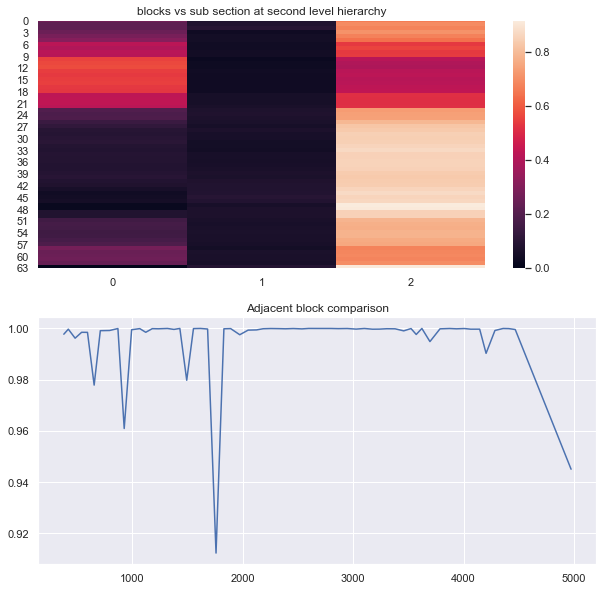

################ GJpt_3ie4WU ################


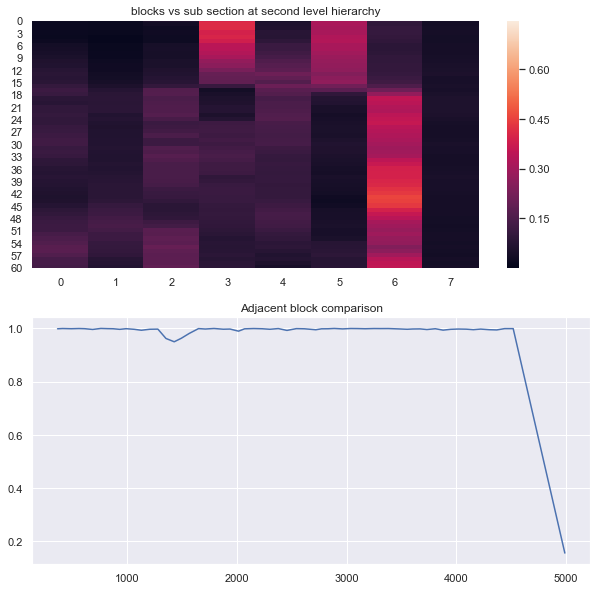

################ h9wxtqoa1jY ################


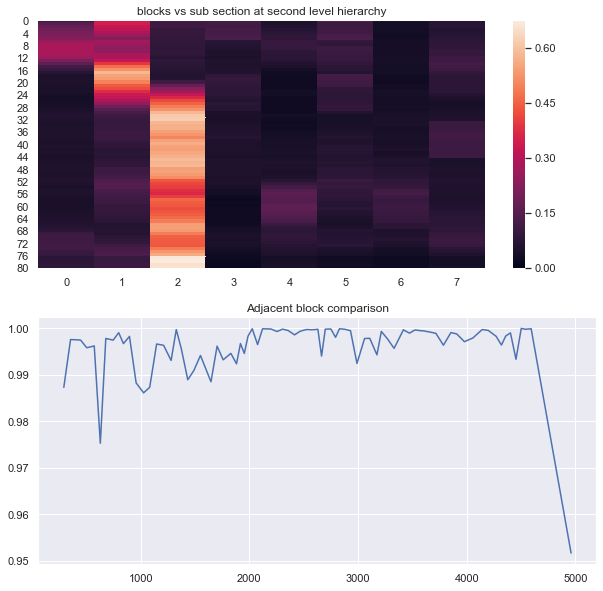

################ NuY7szYSXSw ################


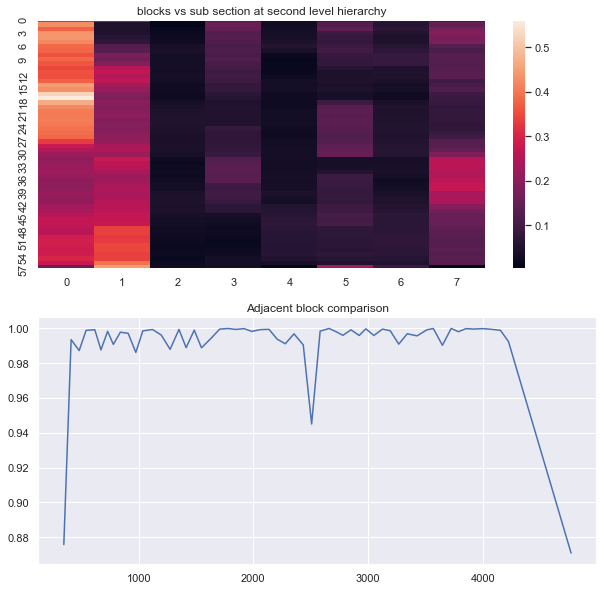

################ XX7ePR21Ook ################


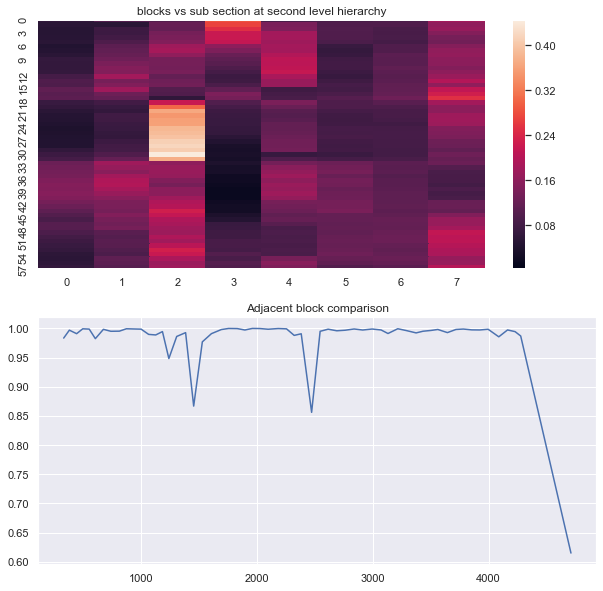

In [50]:
# selected by the majority like in previous notebooks
main_chapters_ = {
    "bTyxpoi2dmM":5,
    "GJpt_3ie4WU":4,
    "h9wxtqoa1jY":4,
    "NuY7szYSXSw":3,
    "XX7ePR21Ook":3
} 
paper_name = 'MIT6_042JF10_notes'
is_print_mess = True
hierarchy_desc = ['first','second','third']

division_results = {}


for vid in videos_ids:
    # PARAMETERS
    window_size =500
    step_size = 40
    df_vid_division = pd.DataFrame(columns=['Title','Start','End'])
    print('################ %s ################' % (vid))
        
    '''Dividing the video transcripts to blocks'''
    block_handler = CreateBlocks(transcripts_jsons[vid])
    blocks = block_handler.partion(method='sliding_window',
                                   window_size=window_size,
                                   step_size_sd=step_size)
    gap_timestamp = block_handler.get_block_gap_timestamp()
    
    ch_main_matching_top,correlation = get_corr_chapters_blocks(blocks,
                                                                paper_content[paper_name]['main titles'],
                                                           main_section_as_one_doc[paper_name]
                                                           )
    ch_main_matching_top_tl = [tp[0] for tp in ch_main_matching_top]
    
    
    knn = 5
    ch_main_matching_top,main_matching_topic_indexes =  find_dominent_chapter_knn(ch_main_matching_top_tl,
                                                  paper_content[paper_name]['main titles'],
                                                 correlation,k_nearest = knn)
    
    #print('main chapters selected:')
    #print(ch_main_matching_top)
    #dom_main_cha_index = main_chapters_[vid] # shortcut for implementing a majority vote
    #################################################################
    '''Second heirarchy level comparison'''
    ##################################################################
    
    '''Finding the text and the titles'''
    dom_subsec_text = [[first_dep_section_as_one_doc[paper_name][s_i]\
                       for s_i in titles_by_hierchy_ranges[0][dom_cha_index]] for dom_cha_index in main_matching_topic_indexes][0]
    dom_subsec_titles = [[tl_first_dep_by_hier[tl_i]
                         for tl_i in titles_by_hierchy_ranges[0][dom_cha_index]] for dom_cha_index in main_matching_topic_indexes][0]
    
    
    '''Find correlation between the corrent chapters to the blocks'''
    hierarchy_level = 0
    
    ch_matching_top,correlation = get_corr_chapters_blocks(blocks,
                                                           dom_subsec_titles,
                                                           dom_subsec_text)
    ch_matching_top_tl = [tp[0] for tp in ch_matching_top]
    subsec_matching_topic,subsec_matching_topic_indexes =  find_dominent_chapter_knn(ch_matching_top_tl,
                                                  dom_subsec_titles,
                                                 correlation,k_nearest = knn)
    
    ################################################################
    '''Printing'''
    ################################################################
    self_corr = cosine_similarity(correlation,correlation)
    '''Plotting'''
    fig,ax = plt.subplots(2,1,figsize=(10,10))
    
    sns.heatmap(correlation,vmin=np.min(correlation),vmax=np.max(correlation),ax=ax[0])
    ax[0].set_title('blocks vs sub section at %s level hierarchy' %(hierarchy_desc[hierarchy_level +1]))
    
    #sns.heatmap(self_corr,vmin=np.min(self_corr),vmax=np.max(self_corr),ax=ax[1])
    #ax[1].set_title('Self Correlation')
    sequential_values = [self_corr[row,row+1] for row in range(self_corr.shape[0] -1)]
    
    #ax[1].plot(list(map(sec_to_min, gap_timestamp)),sequential_values)
    ax[1].plot(gap_timestamp,sequential_values)
    ax[1].set_title('Adjacent block comparison')
    plt.show()
    
    #[print(str(ch_) + " " + str(g_)) for g_,ch_ in zip(gap_timestamp,ch_matching_top)]
    
    #################################################################
    '''Third heirarchy level comparison'''
    ##################################################################
    gap_timestamp_with_end = gap_timestamp.copy()
    gap_timestamp_with_end.append(df_videos.loc[df_videos['video id'] == vid,
                                                'topic shifts(ends)'].values.tolist()[-1])
    
    
    
    #ch_matching_top_titles = [ch[0] for ch in ch_matching_top]
    
    ''' Initiate parameters and Zakif'''
    curr_topic_blocks = [blocks[0]]
    last_shift_seconds = 0
    ch_matching_top.append(('end',-100)) # zakif
    blocks.append([]) # zakif
    '''Find the shifts where in the second hierarchy level it occurs'''
    for tl_i in range(1,len(ch_matching_top)):
        # if it is the same topic
        if  ch_matching_top[tl_i] == ch_matching_top[tl_i-1]:
            #print("continue first dep heirarchy title : "  + str(ch_matching_top[tl_i]))
            curr_topic_blocks.append(blocks[tl_i])
            
        else:
            #print("new first dep heirarchy title : "  + str(ch_matching_top[tl_i]))
            ''' if we have topic shift '''
            #print(past_chapters[-1])
            #print(past_chapters[-1][1])
            dom_main_cha_index = tl_first_dep_by_hier.index(ch_matching_top[tl_i-1][0])
            #print(dom_main_cha_index)
            sub_ch_matching_top,sub_ch_correlations = get_corr_chapters_blocks(curr_topic_blocks,
                                                                               paper_content[paper_name]['titles'],
                                                                               paper_subsec_as_one_doc[paper_name],
                                                                               dom_main_cha_index=dom_main_cha_index,
                                                                                   hierarchy_level=1)
            #print('sub_ch_matching_top len: %s, curr_topic_blocks len %s '
            #      %(len(sub_ch_matching_top),len(curr_topic_blocks) ))
            
            sub_ch_matching_top.append(('end',-100))
            '''try to find where the subtopic shifts'''
            for sub_ch_i in range(1,len(sub_ch_matching_top)):
                '''Sub topic shift'''
                if sub_ch_matching_top[sub_ch_i] != sub_ch_matching_top[sub_ch_i-1]:
                    end_ = gap_timestamp_with_end[tl_i - len(sub_ch_matching_top) + sub_ch_i]
             #       print('switching subtopic from ' + 
             #             str(sub_ch_matching_top[sub_ch_i -1 ]) + 
             #              ' to ' + str(sub_ch_matching_top[sub_ch_i]))
             #       print('start : %s end %s '%(last_shift_seconds,end_))
                    next_sec  = {
                        'Title': sub_ch_matching_top[sub_ch_i - 1][0],
                         'Start': last_shift_seconds,
                         'End':end_
                    }
                    df_vid_division = df_vid_division.append(next_sec,ignore_index=True)
                    last_shift_seconds = end_
            
            curr_topic_blocks = [blocks[tl_i]]
    division_results[vid]  = df_vid_division
    #display(HTML(df_vid_division.to_html()))

    

# Comparing to groundbase

In [51]:
all_results_matching = []

for vid in videos_ids:
    pre_labeled_titles = df_tp_to_ch.loc[df_tp_to_ch['video id'] == vid,
                        ['chapter section','chapter title','chapter confidence']].values.tolist()
    
    pre_labeled_titles.insert(0,{'chapter section':0,'chapter title':'Start of lecture','chapter confidence':0})
    
    '''Find the match between the topics to the chapter at the most granular way'''
    
    shifts = df_videos.loc[df_videos['video id'] == vid,'topic shifts(ends)'].values.tolist()
    groundbase = shifts#[:-1] # not removing the end string - modify it in the next lines
    #videos_division[vid]['topic_shift'][-1] = groundbase[-1] # converting the 'end' string to 
    df_vid_results = pd.DataFrame(columns=['Video',
                                           'Segment Time Range',
                                           'Founded Title',
                                           'Chapter Section',
                                           'Prelabeled Title',
                                           'Groundbase Interval'])
    
    previous_shift = 0
    groundbase.insert(0,0)
    video_algo_division = division_results[vid].values.tolist()
    for topic_i in range(len(video_algo_division)):
        #max_cor = max(corr) # max correlation with that topic
        
        #print(groundbase)
        curr_shift = video_algo_division[topic_i][2]
        intermax_grb_previous_index = 0
        intermax_grb_next_index = 1
        max_intersection = min(curr_shift,groundbase[intermax_grb_next_index]) - max(previous_shift,groundbase[intermax_grb_previous_index])
        for grb_previous_index,grb_next_index in zip(range(0,len(groundbase) - 1,1),range(1,len(groundbase),1)):
            upper_bound = min(curr_shift,groundbase[grb_next_index])
            bottom_bound = max(previous_shift,groundbase[grb_previous_index])
            curr_intersection =  upper_bound- bottom_bound
            if  curr_intersection > max_intersection:
                '''print("topic_i : " + str(topic_i)+ " groundbase[grb_previous_index] : " +str(groundbase[grb_previous_index])+
                      " groundbase[grb_next_index]: " +str(groundbase[grb_next_index]) + ' previous_shift : ' +str(previous_shift)+
                     " curr_shift: " +str(curr_shift)  + 'upper_bound : ' + str(upper_bound) + " bottom_bound: " + str(bottom_bound))
                print('curr_intersection ' +str(curr_intersection) + 'max_intersection ' + str(max_intersection))'''
                intermax_grb_previous_index = grb_previous_index
                intermax_grb_next_index = grb_next_index
                max_intersection = curr_intersection
        
        founded_title = video_algo_division[topic_i][0]
        df_vid_results = df_vid_results.append({
                               'Video' :vid,
                               'Segment Time Range': sec_to_min(previous_shift) + "-"  +sec_to_min(curr_shift),
                               'Founded Title':founded_title,
                               'Chapter Section':pre_labeled_titles[intermax_grb_next_index][0],
                               'Prelabeled Title':pre_labeled_titles[intermax_grb_next_index][1],
                               'Groundbase Interval': sec_to_min(groundbase[intermax_grb_previous_index])+ "-" +sec_to_min(groundbase[intermax_grb_next_index])},ignore_index=True)
        previous_shift = curr_shift

    display(HTML(df_vid_results[[
                                'Segment Time Range',
                                'Founded Title',
                                'Chapter Section',
                                'Prelabeled Title',
                                 'Groundbase Interval']].to_html()))
    display(df_tp_to_ch.loc[df_tp_to_ch['video id'] == vid])
    all_results_matching.append(df_vid_results)



,Segment Time Range,Founded Title,Chapter Section,Prelabeled Title,Groundbase Interval
0,00:00:00-00:15:29,6.3.3 Network Diameter,6.3.3,Network Diameter,00:06:00-00:11:05
1,00:15:29-00:24:55,6.1 Definitions,6.3.6,Congestion,00:16:25-00:27:00
2,00:24:55-00:28:04,6.3.6 Congestion,6.3.6,Congestion,00:16:25-00:27:00
3,00:28:04-00:34:10,6.3.7 The two dimensional array,6.3.7,The 2-d Array,00:27:00-00:37:13
4,00:34:10-00:36:27,6.3.4 Switch Size,6.3.7,The 2-d Array,00:27:00-00:37:13
5,00:36:27-00:52:56,6.3.8 The Butterfly,6.3.8,The Butterfly,00:37:13-00:53:40
6,00:52:56-00:55:05,6.3.3 Network Diameter,6.3.9,Benes Network,00:53:40-01:23:24
7,00:55:05-00:59:32,6.3.1 Packet Routing,6.3.9,Benes Network,00:53:40-01:23:24
8,00:59:32-01:22:53,6.3.9 Benesˇ Network,6.3.9,Benes Network,00:53:40-01:23:24
9,01:22:53-01:23:24,6.3.2 The Complete Binary Tree,6.3.9,Benes Network,00:53:40-01:23:24


,shift index,topic shifts(ends),label,video,video id,chapter section,chapter title,chapter confidence,notes
94,0,00:01:30,None,None,bTyxpoi2dmM,6.3,Communication Networks,None,None
95,1,00:06:00,None,None,bTyxpoi2dmM,6.3.2,The Complete Binary Tree,None,None
96,2,00:11:05,None,None,bTyxpoi2dmM,6.3.3,Network Diameter,None,None
97,3,00:14:45,None,None,bTyxpoi2dmM,6.3.4,Switch Size,None,None
98,4,00:16:25,None,None,bTyxpoi2dmM,6.3.5,Switch Count,None,None
99,5,00:27:00,None,None,bTyxpoi2dmM,6.3.6,Congestion,None,None
100,6,00:37:13,None,None,bTyxpoi2dmM,6.3.7,The 2-d Array,None,None
101,7,00:53:40,None,None,bTyxpoi2dmM,6.3.8,The Butterfly,None,None
102,8,01:23:24,None,None,bTyxpoi2dmM,6.3.9,Benes Network,None,None


,Segment Time Range,Founded Title,Chapter Section,Prelabeled Title,Groundbase Interval
0,00:00:00-00:15:30,5.4.1 Paths and Walks,5.4.2,Finding a Path,00:05:24-00:12:13
1,00:15:30-00:23:47,5.6.1 Cycles and Closed Walks,5.7.2,Properties,00:18:55-00:30:20
2,00:23:47-00:26:03,5.7.2 Properties,5.7.2,Properties,00:18:55-00:30:20
3,00:26:03-00:27:28,5.7.4 Minimum Weight Spanning Trees,5.7.2,Properties,00:18:55-00:30:20
4,00:27:28-00:48:06,5.7.2 Properties,5.7.3,Spanning Trees,00:30:20-00:44:33
5,00:48:06-01:08:09,5.7.4 Minimum Weight Spanning Trees,5.7.4,Minimum Weight Spanning Trees,00:44:33-01:23:25
6,01:08:09-01:23:07,5.7.2 Properties,5.7.4,Minimum Weight Spanning Trees,00:44:33-01:23:25
7,01:23:07-01:23:25,5.5.2,5.7.4,Minimum Weight Spanning Trees,00:44:33-01:23:25


,shift index,topic shifts(ends),label,video,video id,chapter section,chapter title,chapter confidence,notes
86,0,00:05:24,None,None,GJpt_3ie4WU,5.4.1,Paths and Walks,None,None
87,1,00:12:13,None,None,GJpt_3ie4WU,5.4.2,Finding a Path,None,None
88,2,00:14:15,None,None,GJpt_3ie4WU,5.5,Connectivity,None,None
89,3,00:16:55,None,None,GJpt_3ie4WU,5.6.1,Cycles and Closed Walks,None,None
90,4,00:18:55,None,None,GJpt_3ie4WU,5.7.1,Definitions,None,None
91,5,00:30:20,None,None,GJpt_3ie4WU,5.7.2,Properties,None,None
92,6,00:44:33,None,None,GJpt_3ie4WU,5.7.3,Spanning Trees,None,None
93,7,01:23:25,None,None,GJpt_3ie4WU,5.7.4,Minimum Weight Spanning Trees,None,None


,Segment Time Range,Founded Title,Chapter Section,Prelabeled Title,Groundbase Interval
0,00:00:00-00:09:32,5.2.1 Sex in America,5.2.1,Sex in America,00:00:00-00:08:29
1,00:09:32-00:10:28,5.1.1 Simple Graphs,5,Graph Theory,00:08:29-00:12:00
2,00:10:28-00:11:18,5.2.1 Sex in America,5,Graph Theory,00:08:29-00:12:00
3,00:11:18-00:14:00,5.1.1 Simple Graphs,5.1.1,Simple Graphs,00:12:47-00:16:20
4,00:14:00-00:17:06,5.2.1 Bipartite Matchings,5.1.1,Simple Graphs,00:12:47-00:16:20
5,00:17:06-00:28:22,5.2.1 Sex in America,5.2.1,Sex in America,00:16:20-00:27:40
6,00:28:22-00:53:34,5.3.1 An Exam Scheduling Problem,5.3.3,Why Coloring?,00:33:00-00:42:50
7,00:53:34-01:11:59,5.3.2 Degree-Bounded Coloring,5.3.2,Degree-Bounded Coloring,00:49:40-01:16:00
8,01:11:59-01:22:40,5.3.3 Why coloring?,5.3.3,Why Coloring?,01:17:42-01:22:50
9,01:22:40-01:22:50,5.3.1 An Exam Scheduling Problem,5.3.3,Why Coloring?,01:17:42-01:22:50


,shift index,topic shifts(ends),label,video,video id,chapter section,chapter title,chapter confidence,notes
75,0,00:08:29,None,None,h9wxtqoa1jY,5.2.1,Sex in America,None,None
76,1,00:12:00,None,None,h9wxtqoa1jY,5,Graph Theory,None,None
77,2,00:12:47,talk about the empty graph,None,h9wxtqoa1jY,5.1.2,Some Common Graphs,None,None
78,3,00:16:20,Def 5.1.2,None,h9wxtqoa1jY,5.1.1,Simple Graphs,None,None
79,4,00:27:40,None,None,h9wxtqoa1jY,5.2.1,Sex in America,None,None
80,5,00:33:00,None,None,h9wxtqoa1jY,5.3.1,An Exam Scheduling Problem,None,None
81,6,00:42:50,None,None,h9wxtqoa1jY,5.3.3,Why Coloring?,None,None
82,7,00:49:40,None,None,h9wxtqoa1jY,5.3.1,An Exam Scheduling Problem,None,None
83,8,01:16:00,None,None,h9wxtqoa1jY,5.3.2,Degree-Bounded Coloring,None,None
84,9,01:17:42,None,None,h9wxtqoa1jY,5.2.2,Bipartite Matchings,None,None


,Segment Time Range,Founded Title,Chapter Section,Prelabeled Title,Groundbase Interval
0,00:00:00-00:21:14,4.1.3 Die Hard,4.1.3,Die Hard,00:09:50-00:30:35
1,00:21:14-00:23:34,4.1 Divisibility,4.1.3,Die Hard,00:09:50-00:30:35
2,00:23:34-00:40:35,4.1.3 Die Hard,4.1.3,Die Hard,00:09:50-00:30:35
3,00:40:35-00:43:02,4.2.3 Euclid’s Algorithm,4.2.1,Linear Combinations and the GCD,00:34:50-00:42:50
4,00:43:02-00:53:13,4.8 The RSA Algorithm,4.2.4,None,00:42:50-00:57:50
5,00:53:13-00:54:27,4.2.3 Euclid’s Algorithm,4.2.4,None,00:42:50-00:57:50
6,00:54:27-00:58:34,4.2.4 One Solution for All Water Jug Problems,4.2.4,None,00:42:50-00:57:50
7,00:58:34-01:19:30,4.2.3 Euclid’s Algorithm,4.2.5,The Pulverizer,00:57:50-01:12:00
8,01:19:30-01:20:24,4.2.1 Linear Combinations and the GCD,4.2.1,Linear Combinations and the GCD,01:12:00-01:20:24


,shift index,topic shifts(ends),label,video,video id,chapter section,chapter title,chapter confidence,notes
54,0,00:02:47,introduction,None,NuY7szYSXSw,4,Number Theory,None,None
55,1,00:08:40,None,None,NuY7szYSXSw,4.1.3,Die Hard,None,None
56,2,00:09:50,basic definition,None,NuY7szYSXSw,4.1,Divisibility,None,None
57,3,00:30:35,None,None,NuY7szYSXSw,4.1.3,Die Hard,None,None
58,4,00:33:48,None,None,NuY7szYSXSw,4.2,The Greatest Common Divisor,None,None
59,5,00:34:50,None,None,NuY7szYSXSw,4.7.1,Relative Primality,None,None
60,6,00:42:50,None,None,NuY7szYSXSw,4.2.1,Linear Combinations and the GCD,None,None
61,7,00:57:50,None,None,NuY7szYSXSw,4.2.4,None,None,None
62,8,01:12:00,None,None,NuY7szYSXSw,4.2.5,The Pulverizer,None,None
63,9,01:20:24,None,None,NuY7szYSXSw,4.2.1,Linear Combinations and the GCD,None,None


,Segment Time Range,Founded Title,Chapter Section,Prelabeled Title,Groundbase Interval
0,00:00:00-00:10:09,4.4.1 Turing,4.4,Alan Turing,00:00:00-00:05:00
1,00:10:09-00:11:18,4.5 Modular Arithmetic,4.4.2,Breaking Turing’s Code,00:09:12-00:11:05
2,00:11:18-00:12:23,4.3 The Fundamental Theorem of Arithmetic,4.5.1,Turing’s Code (Version 2.0),00:11:05-00:13:45
3,00:12:23-00:18:50,4.5 Modular Arithmetic,4.5,Modular Arithmetic,00:15:45-00:17:52
4,00:18:50-00:19:48,4.8 The RSA Algorithm,4.6.1,Multiplicative Invers,00:17:52-00:25:35
5,00:19:48-00:20:43,4.5 Modular Arithmetic,4.6.1,Multiplicative Invers,00:17:52-00:25:35
6,00:20:43-00:24:17,4.8 The RSA Algorithm,4.6.1,Multiplicative Invers,00:17:52-00:25:35
7,00:24:17-00:41:14,4.3 The Fundamental Theorem of Arithmetic,4.7.2,Euler’s Theorm,00:32:00-00:59:30
8,00:41:14-00:42:27,4.2.2 Properties of the Greatest Common Divisor,4.7.2,Euler’s Theorm,00:32:00-00:59:30
9,00:42:27-00:44:51,4.3 The Fundamental Theorem of Arithmetic,4.7.2,Euler’s Theorm,00:32:00-00:59:30


,shift index,topic shifts(ends),label,video,video id,chapter section,chapter title,chapter confidence,notes
64,0,00:05:00,None,None,XX7ePR21Ook,4.4,Alan Turing,None,None
65,1,00:09:12,None,None,XX7ePR21Ook,4.4.1,Turing’s Code (Version 1.0),None,None
66,2,00:11:05,None,None,XX7ePR21Ook,4.4.2,Breaking Turing’s Code,None,None
67,3,00:13:45,None,None,XX7ePR21Ook,4.5.1,Turing’s Code (Version 2.0),None,None
68,4,00:15:45,None,None,XX7ePR21Ook,4.7.1,Relative Primality,None,None
69,5,00:17:52,None,None,XX7ePR21Ook,4.5,Modular Arithmetic,None,None
70,6,00:25:35,None,None,XX7ePR21Ook,4.6.1,Multiplicative Invers,None,None
71,7,00:32:00,None,None,XX7ePR21Ook,4.6.4,Breaking Turing’s Code—Again,None,None
72,8,00:59:30,None,None,XX7ePR21Ook,4.7.2,Euler’s Theorm,None,None
73,9,01:03:30,None,None,XX7ePR21Ook,4.6.3,Fermat’s Little Theorem,None,None


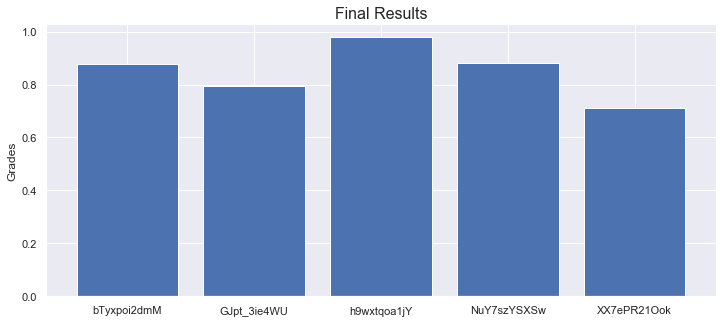

In [52]:
def hit_ratio(founded_section,labeled_section):
    founded_subsection_nums = founded_section.split('.')
    labeled_subsection_nums = labeled_section.split('.')
    k = min(len(founded_subsection_nums),len(labeled_subsection_nums))
    sub_ratios = []
    for level in range(k):
        my_log = np.log(abs(int(founded_subsection_nums[level]) - int(labeled_subsection_nums[level]) + 1))
        sub_ratios.append(1/((my_log +1) **(level + 1)))
    return sum(sub_ratios)/k

'''Calculate grade for each video matching '''
videos_ = []
grades = []
for df_vid_results in all_results_matching:
    founded_titles = df_vid_results['Founded Title'].values.tolist()
    founded_sections = list(map(lambda x: re.match(r'((\d+\.)+\d*)',x).groups()[0],founded_titles))
    labeled_sections = df_vid_results['Chapter Section'].values.tolist()
    grades.append(sum(list(map(lambda x,y: hit_ratio(x,y),
                       founded_sections,labeled_sections)))/len(founded_sections))
    videos_.append(df_vid_results['Video'].values.tolist()[0])
    
fig,ax = plt.subplots(figsize = (12,5))    
pos_ = np.arange(len(videos_))
ax.bar(pos_,grades)

ax.set_ylabel('Grades')
ax.set_title('Final Results',fontsize=16)
ax.set_xticks(pos_)
ax.set_xticklabels(videos_)

plt.show()

In [53]:
print(grades)
print(sum(grades)/len(grades))

[0.8782459025496377, 0.7961747519513123, 0.9782942462795688, 0.8807791568126188, 0.7128041094752228]
0.849259633413672
